# Klasyfikacja wydzwięku twetów

Celem poniższego projektu jest próba przewidzenia sentymentu (pozytywnego / negatywnwgo) zawartego w wiadomościach udostępnianych w serwisie Tweeter.
<br />
<br />
W pierwszym kroku importowane są wszystkie bibkioteki wykorzystywane w projekcie

In [1]:
import pandas as pd
import nltk
import string
import random
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

Pobieranie danych. <br />
Połaczenie 3 zbiorów w jeden obiekt DataFrame

In [2]:
nazwy_kolumn = ["Tresc", "Klasyfikacja"]
tweet_set1 = pd.read_table("./zrodlo/amazon_cells_labelled.txt", delimiter="\t", header=None, names=nazwy_kolumn, encoding="utf-8")
tweet_set2 = pd.read_table("./zrodlo/imdb_labelled.txt", delimiter="\t", header=None, names=nazwy_kolumn, encoding="utf-8")
tweet_set3 = pd.read_table("./zrodlo/yelp_labelled.txt", delimiter="\t", header=None, names=nazwy_kolumn, encoding="utf-8")

df_tweet = tweet_set1.append(tweet_set2).append(tweet_set3)
df_tweet.reset_index(inplace=True)

df_tweet.head()

,index,Tresc,Klasyfikacja
0,0,So there is no way for me to plug it in here i...,0
1,1,"Good case, Excellent value.",1
2,2,Great for the jawbone.,1
3,3,Tied to charger for conversations lasting more...,0
4,4,The mic is great.,1


Usunięcie indexu

In [3]:
df_tweet = df_tweet.drop(['index'], axis=1)
df_tweet.head(3)

,Tresc,Klasyfikacja
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1


Porównanie ilości tweetów pozytywnych vs negatywnych

In [4]:
pozytywne_filtr = df_tweet['Klasyfikacja'] == 1
pozytywne = df_tweet[pozytywne_filtr]

negatywne_filtr = df_tweet['Klasyfikacja'] == 0
negatywne = df_tweet[negatywne_filtr]

print('%35s %5d' %('Ilośc tweetów pozytywnych:', len(pozytywne)))
print('%35s %5d' %('Ilośc tweetów negatwynych:', len(negatywne)))
print('%35s %5d' %('Ilośc wszystkich badanych tweetów:', df_tweet.shape[0]))

         Ilośc tweetów pozytywnych:  1386
         Ilośc tweetów negatwynych:  1362
 Ilośc wszystkich badanych tweetów:  2748


20 najczęściej używanych słów w całym zbiorze danych

   Wszystkich słów w zbiorze danych jest: 372429
   Unikalnych słów w zbiorze danych jest: 81039


20 najczęściej występujących słów to:
 [('', 1752), ('the', 1473), ('and', 1095), ('a', 846), ('I', 825), ('is', 730), ('to', 652), ('of', 608), ('was', 557), ('this', 442), ('The', 415), ('it', 396), ('in', 373), ('for', 315), ('that', 275), ('with', 263), ('not', 256), ('my', 212), ('on', 203), ('very', 194)]


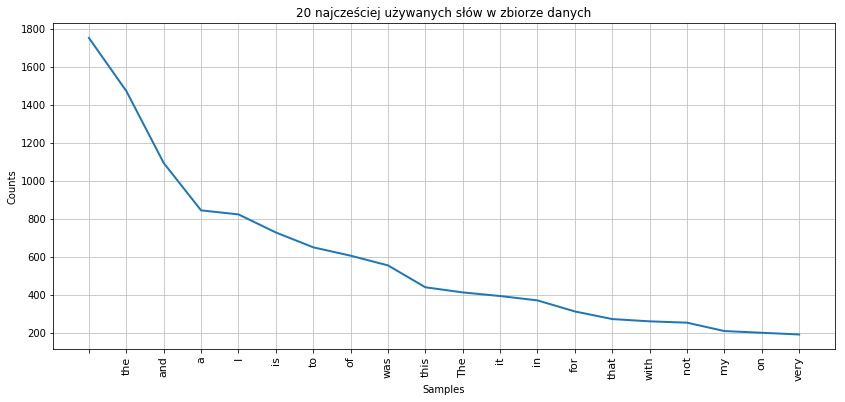

In [5]:
wszystkie_slowa = []
for wiersz in df_tweet["Tresc"]:
    for slowo in wiersz.split(' '):
        wszystkie_slowa.append(slowo)
    
print('%41s %d9' %('Wszystkich słów w zbiorze danych jest:', len(wszystkie_slowa)))
print('%41s %d9' %('Unikalnych słów w zbiorze danych jest:', len(set(wszystkie_slowa))))
print("\n")
print("20 najczęściej występujących słów to:\n",Counter(wszystkie_slowa).most_common(20))

plt.figure(figsize=(14,6))
plt.title('20 najcześciej używanych słów w zbiorze danych')
plt.xticks(fontsize=11, rotation=90)
fd = nltk.FreqDist(wszystkie_slowa)
fd.plot(20)

Funkcje wykorzystywane do czyszczenia wiadomości

In [6]:
def podzial_na_slowa(tweet):
    return word_tokenize(tweet)

def zamiana_cyfr_na_str(tweet):
    tweet = [slowo if not slowo.isdigit() else "<NUMBER>" for slowo in tweet]
    tweet = ''.join(tweet)
    return tweet

def zamiana_na_male_znaki(tweet):
    tweet = [slowo.lower() for slowo in tweet]
    tweet = ''.join(tweet)
    return tweet

def lematyzacja(tweet):
    wordnet_lemmatizer = WordNetLemmatizer()
    tweet = [wordnet_lemmatizer.lemmatize(slowo) for slowo in tweet]
    tweet = ''.join(tweet)
    return tweet

def usuniecie_interpunkcji(tweet):
    tweet = [znak if not znak in string.punctuation else " " for znak in tweet]
    tweet = ''.join(tweet)
    return tweet

def usuniecie_stopwords(tweet):
    tweet = [slowo for slowo in tweet.split(' ') if slowo not in stopwords.words('english')]
    tweet = ' '.join(tweet)
    return tweet

def negacja(tweet):
    tweet = [slowo if "n't" else "<NEGATION>" for slowo in tweet]
    return tweet

def usuniecie_duplikatow(tweet):
    tweet = tweet.replace("    ","").replace("   ","").replace("  "," ").strip()
    tweet = tweet.replace("<NUMBER><NUMBER>", "").strip()
    return tweet

def tokenizacja(tweet):
    tweet = usuniecie_interpunkcji(tweet)    
    tweet = zamiana_na_male_znaki(tweet)
    tweet = negacja(tweet)    
    tweet = zamiana_cyfr_na_str(tweet)
    tweet = lematyzacja(tweet) 
    tweet = usuniecie_stopwords(tweet)
    tweet = usuniecie_duplikatow(tweet)    
    return tweet

df_tweet.head(7)

,Tresc,Klasyfikacja
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
5,I have to jiggle the plug to get it to line up...,0
6,If you have several dozen or several hundred c...,0


Wykonanie powyższych funkcji na zbiorze danych

In [7]:
df_tweet["Tresc_wyczyszczona"] = df_tweet["Tresc"].apply(tokenizacja)

Porównanie losowego tweeta przed i po czyszczeniu

In [8]:
maximum = len(df_tweet) - 1
a = random.randint(0, maximum)

print("Tweet przed czyszczeniem:")
print(df_tweet['Tresc'][a])
print('\n')
print("Tweet po czyszczeniu:")
print(df_tweet['Tresc_wyczyszczona'][a])

Tweet przed czyszczeniem:
But I thought his acting was skilled.  


Tweet po czyszczeniu:
thought acting skilled


20 najczęściej używanych słów po przeprocesowaniu wiadomości (tweetów)

Po wyczyszczeniu zbioru wszystkich słów zostało: 179879
Po wyczyszczeniu zbioru unikalnych slow zostało: 53239


15 najczęściej występujących słów to:
 [('good', 220), ('great', 202), ('movie', 170), ('phone', 165), ('film', 151), ('one', 139), ('<NUMBER>', 130), ('food', 122), ('like', 121), ('place', 114), ('time', 106), ('service', 106), ('really', 102), ('', 93), ('bad', 89), ('would', 85), ('well', 85), ('best', 78), ('even', 75), ('back', 73)]


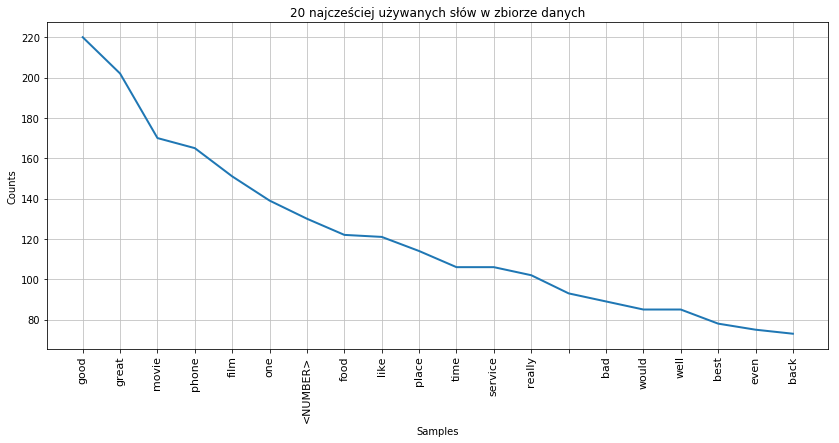

In [9]:
wszystkie_slowa = []
for wiersz in df_tweet["Tresc_wyczyszczona"]:
    for slowo in wiersz.split(' '):
        wszystkie_slowa.append(slowo)
    
print('%44s %d9' %('Po wyczyszczeniu zbioru wszystkich słów zostało:', len(wszystkie_slowa)))
print('%41s %d9' %('Po wyczyszczeniu zbioru unikalnych slow zostało:', len(set(wszystkie_slowa))))
print("\n")
print("15 najczęściej występujących słów to:\n",Counter(wszystkie_slowa).most_common(20))


plt.figure(figsize=(14,6))
plt.title('20 najcześciej używanych słów w zbiorze danych')
plt.xticks(fontsize=11, rotation=90)
fd = nltk.FreqDist(wszystkie_slowa)
fd.plot(20)

Reprezentacja dwustu pierwszych słów po wyczyszczeniu zbioru danych, z ich wagami:

In [10]:
vectorizer = TfidfVectorizer()
vectorizer.fit(df_tweet['Tresc_wyczyszczona'])

slownik = vectorizer.vocabulary_
slownik = {i: slownik[i] for i in list(slownik)[:200]}
print(slownik)

{'way': 4965, 'plug': 3345, 'us': 4816, 'unless': 4775, 'go': 1936, 'converter': 948, 'good': 1948, 'case': 641, 'excellent': 1546, 'value': 4839, 'great': 1984, 'jawbone': 2403, 'tied': 4566, 'charger': 699, 'conversations': 947, 'lasting': 2522, 'minutes': 2855, 'major': 2717, 'problems': 3442, 'mic': 2833, 'jiggle': 2418, 'get': 1905, 'line': 2607, 'right': 3739, 'decent': 1109, 'volume': 4905, 'several': 3975, 'dozen': 1312, 'hundred': 2219, 'contacts': 922, 'imagine': 2254, 'fun': 1854, 'sending': 3938, 'one': 3080, 'razr': 3574, 'ownermust': 3150, 'needless': 2969, 'say': 3855, 'wasted': 4952, 'money': 2881, 'waste': 4951, 'time': 4570, 'sound': 4174, 'quality': 3531, 'impressed': 2265, 'going': 1942, 'original': 3107, 'battery': 342, 'extended': 1590, 'two': 4713, 'seperated': 3949, 'mere': 2818, 'number': 3033, 'ft': 1846, 'started': 4250, 'notice': 3028, 'excessive': 1552, 'static': 4256, 'garbled': 1876, 'headset': 2083, 'though': 4539, 'design': 1170, 'odd': 3053, 'ear': 137

Wiersze reprezentują wiadomości, a kolumny słowa

In [11]:
tfidf_matrix = vectorizer.transform(df_tweet['Tresc_wyczyszczona']).todense()
print(tfidf_matrix.shape)
print(tfidf_matrix)

(2748, 5129)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Redukcja wymiaru

In [12]:
svd = TruncatedSVD(n_components=12) 
svd.fit(tfidf_matrix)

docs_red = svd.transform(tfidf_matrix)
docs_red

array([[ 0.02779823,  0.02127648,  0.10926956, ...,  0.02195189,
         0.01148998, -0.00846533],
       [ 0.18039597,  0.29090122, -0.10869876, ...,  0.01995757,
         0.02192695, -0.08921644],
       [ 0.32235283, -0.22379958, -0.09408868, ...,  0.01706244,
        -0.03133706,  0.02299789],
       ...,
       [ 0.0718412 ,  0.062112  ,  0.42685542, ..., -0.06147226,
         0.06145986,  0.11763801],
       [ 0.04397445,  0.04007493,  0.14577318, ..., -0.00873966,
        -0.01257118, -0.03427735],
       [ 0.02518191,  0.02766851,  0.03967528, ..., -0.01186615,
        -0.01206529,  0.00225353]])

Przygotowany zbiór danych dzielony jest na zbiór testowy i uczony. Proporcje podziału zaprezentowano na diagramie

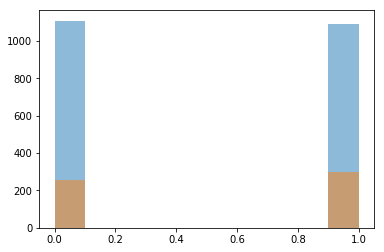

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df_tweet['Tresc_wyczyszczona'], df_tweet['Klasyfikacja'], test_size=0.2)

plt.hist(y_train, alpha=0.5)
plt.hist(y_test, alpha=0.5)
plt.show()

Poniżej użyto 4 metod klasyfikacji do próby przewidzenia sentymentu wiadomości "tweet" w zbiorze danych

**Model Regresja Liniowa**

In [14]:
pipe_1 = Pipeline([
    ('vectorizer', CountVectorizer()), 
    ("SVD", TruncatedSVD(n_components=12)),
    ('classifier', LogisticRegression(C=1, solver='lbfgs'))
])

param_grid_1 = {
            'vectorizer': [TfidfVectorizer(), 
                           CountVectorizer()],   
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

kfold = StratifiedKFold(n_splits=5)

grid_1 = GridSearchCV(pipe_1, param_grid_1, cv=kfold, return_train_score=True)

grid_1.fit(X_train, y_train)
grid_1.best_params_

{'classifier__C': 10,
 'vectorizer': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 1), preprocessor=None, stop_words=None,
         strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
         tokenizer=None, vocabulary=None)}

**Model Drzewo Decyzyjne**

In [15]:
pipe_2 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('SVD', TruncatedSVD(n_components=12)),
    ('classifier', DecisionTreeClassifier())
])

param_grid_2 = {
            'vectorizer': [TfidfVectorizer(), 
                           CountVectorizer()],    
            'classifier__max_depth': [5,10,30],
            'classifier__min_samples_split': [2,5,10,50],
            'classifier__max_leaf_nodes': [3,10,15,20,50]
}

kfold = StratifiedKFold(n_splits=5)

grid_2 = GridSearchCV(pipe_2, param_grid_2, cv=kfold, return_train_score=True)

grid_2.fit(X_train, y_train)
grid_2.best_params_

{'classifier__max_depth': 30,
 'classifier__max_leaf_nodes': 15,
 'classifier__min_samples_split': 2,
 'vectorizer': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
         stop_words=None, strip_accents=None, sublinear_tf=False,
         token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
         vocabulary=None)}

**Model SVC**

In [16]:
pipe_3 = Pipeline([
    ('vectorizer', CountVectorizer()), 
    ('SVD', TruncatedSVD(n_components=12)),
    ('classifier', SVC(C=1, probability=True))
])

param_grid_3 = {
            'vectorizer': [TfidfVectorizer(), 
                           CountVectorizer()],
            'classifier__C': [0.01, 0.1, 1, 10, 100,],
            'classifier__gamma': [0.01, 0.1, 1, 10, 100]
}

kfold = StratifiedKFold(n_splits=5)

grid_3 = GridSearchCV(pipe_3, param_grid_3, cv=kfold, return_train_score=True)

grid_3.fit(X_train, y_train)
grid_3.best_params_

{'classifier__C': 100,
 'classifier__gamma': 10,
 'vectorizer': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
         stop_words=None, strip_accents=None, sublinear_tf=False,
         token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
         vocabulary=None)}

**Model Las Losowy**

In [17]:
pipe_4 = Pipeline([('vectorizer', CountVectorizer()),
                   ("SVD", TruncatedSVD(n_components=12)),
                   ('classifier', RandomForestClassifier(max_leaf_nodes=16))
                  ])

param_grid_4 = {
            'vectorizer': [TfidfVectorizer(), 
                           CountVectorizer()],    
            'classifier__n_estimators': [10, 50, 100],
            'classifier__max_leaf_nodes': [10, 20],
            'classifier__max_depth': [10, 20]
             }

kfold = StratifiedKFold(n_splits=5)

grid_4 = GridSearchCV(pipe_4, param_grid_4, cv=kfold, return_train_score=True)

grid_4.fit(X_train, y_train)
grid_4.best_params_

{'classifier__max_depth': 10,
 'classifier__max_leaf_nodes': 20,
 'classifier__n_estimators': 50,
 'vectorizer': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
         stop_words=None, strip_accents=None, sublinear_tf=False,
         token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
         vocabulary=None)}

In [18]:
modele = []
modele.append(('Regresja logistyczna', grid_1.best_estimator_))
modele.append(('Drzewo decyzyjne', grid_2.best_estimator_))
modele.append(('SVM', grid_3.best_estimator_))
modele.append(('Las Losowy', grid_4.best_estimator_))

precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
roc_auc_score = []
for nazwa, model in modele:
    print(nazwa)
    print("Precyzja: {}".format(metrics.precision_score(y_test , model.predict(X_test), average='weighted') ))
    print("Czułość: {}".format( metrics.recall_score(y_test , model.predict(X_test), average='weighted') ))
    print("Miara F1 - średnia harmoniczna z precyzji i czułości: {}".format( metrics.f1_score(y_test , model.predict(X_test), average='weighted') ))
    print("Dokładność: {}".format( metrics.accuracy_score(y_test , model.predict(X_test)) ))
    print('\n')
    

    precision_score.append(metrics.precision_score(y_test , model.predict(X_test), average='weighted') )
    recall_score.append(metrics.recall_score(y_test , model.predict(X_test), average='weighted') )
    f1_score.append( metrics.f1_score(y_test , model.predict(X_test), average='weighted') )
    accuracy_score.append(metrics.accuracy_score(y_test , model.predict(X_test)))


Regresja logistyczna
Precyzja: 0.6773442221314823
Czułość: 0.62
Miara F1 - średnia harmoniczna z precyzji i czułości: 0.6018775602239843
Dokładność: 0.62


Drzewo decyzyjne
Precyzja: 0.6366627565982405
Czułość: 0.6254545454545455
Miara F1 - średnia harmoniczna z precyzji i czułości: 0.624483193317744
Dokładność: 0.6254545454545455


SVM
Precyzja: 0.662657701636425
Czułość: 0.649090909090909
Miara F1 - średnia harmoniczna z precyzji i czułości: 0.6477448278621911
Dokładność: 0.649090909090909


Las Losowy
Precyzja: 0.6811079291373439
Czułość: 0.6527272727272727
Miara F1 - średnia harmoniczna z precyzji i czułości: 0.6472350418580316
Dokładność: 0.6527272727272727




In [19]:
wyniki = pd.DataFrame({'Model': ['Regresja logistyczna', 'Drzewo decyzyjne', 'SVM', 'Las Losowy'],
                                   'Dokładność': [accuracy_score[0],
                                                  accuracy_score[1],
                                                  accuracy_score[2],
                                                  accuracy_score[3]]})
wyniki

,Model,Dokładność
0,Regresja logistyczna,0.620000
1,Drzewo decyzyjne,0.625455
2,SVM,0.649091
3,Las Losowy,0.652727


Przed wykorzystaniem danych w modelach klasyfikacji, te zostały wcześniej wyczyszczone. W tym procesie wykonano: <br />
- podział tweetów na słowa,
- zamieniono wszystkie cyfry występujące w widomościach na słowo 'NUMBER',
- zmieniono wszystkie znaki na nałe litery,
- lematyzację,
- usunięto interpunkcję,
- usunięto najczęśniej uzywane słowa (stopwords),
- zamieniono ciąg znaków "n't" na słowo "negation"<br /><br />

Wszystkie modele dały zbliżone wyniki. Najlepiej z problemem klasyfikacji poradził sobie Las Losowy. Wynik 65% pokazuje jednak, że próba przewidzenia sentymentu wiadomości nie jest problemem łatwym do rozwiązania. <br />
Model klasyfikujące treść, używane są na forach oraz portalach społecznościowych próbując wyłapać podejrzane treści np. rasistowskie lub nawołujące do przemocy. W mojej opinii modele sparametryzowane pod szukanie treści konkretnego tematu powinny dawać lepsze wyniki.